## Lab №2 NMT

Summary

Предобработка данных
Во всех решениях для токенизации использовал mystem для русского и nltk для английского текста

Baseline

Для решения из бейзлайна применил инициализацию весов Ксавьера.

Пробовал шедулеры для LR (ReduceLROnPlateau и StepLR), в результате получил улучшение по loss, но BLEU ухудшилось. От шедулеров отказался

Увеличивал количество слоёв в энкодере и декодере до 4, как результат - дольше учился и лучше результата

Учил бейзлайн до ~40 эпох, лучший результат по BLEU ~21

Attention
Учил сеть с механизмом attention, в качестве RNN элемента - GRU с одним слоем

8 эпох - BLEU ~ 28.6, на colab ~82 секунды на эпоху

Seq2Seq( (encoder): Encoder( (embedding): Embedding(6552, 256) (rnn): GRU(256, 512, bidirectional=True) (fc): Linear(in_features=1024, out_features=512, bias=True) (dropout): Dropout(p=0.5, inplace=False) ) (decoder): Decoder( (attention): Attention( (attn): Linear(in_features=1536, out_features=512, bias=True) (v): Linear(in_features=512, out_features=1, bias=False) ) (embedding): Embedding(6784, 256) (rnn): GRU(1280, 512) (fc_out): Linear(in_features=1792, out_features=6784, bias=True) (dropout): Dropout(p=0.5, inplace=False) ) )
Реализация приложена в виде ноутбука и py файлов

# Загрузка данных и пакетов

In [1]:
!pip uninstall -q torch
!pip uninstall -q torchvision
!pip uninstall -q torchtext
!pip install -q torchvision==0.6.0
!pip install -q torch==1.5.0
!pip install -q torchtext==0.3.1

Proceed (y/n)? y
     |████████████████████████████████| 6.6MB 21.5MB/s 


In [2]:
! pip  install subword-nmt
! pip install nltk
! pip install torchtext

In [4]:
# Thanks to YSDA NLP course team for the data
# (who thanks tilda and deephack teams for the data in their turn)

import os
path_do_data = '../../datasets/Machine_translation_EN_RU/data.txt'
if not os.path.exists(path_do_data):
    print("Dataset not found locally. Downloading from github. Loading special files as well")
    !wget https://raw.githubusercontent.com/neychev/made_nlp_course/spring2021/datasets/Machine_translation_EN_RU/data.txt -nc
    path_do_data = './data.txt'

Dataset not found locally. Downloading from github. Loading special files as well
--2021-06-08 21:47:04--  https://raw.githubusercontent.com/neychev/made_nlp_course/spring2021/datasets/Machine_translation_EN_RU/data.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12905334 (12M) [text/plain]
Saving to: ‘data.txt’

data.txt            100%[===================>]  12.31M  --.-KB/s    in 0.09s   

2021-06-08 21:47:04 (141 MB/s) - ‘data.txt’ saved [12905334/12905334]



In [3]:
!wget http://download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz
!tar -xvf mystem-3.0-linux3.1-64bit.tar.gz
!cp mystem /bin

--2021-06-08 21:47:00--  http://download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz
Resolving download.cdn.yandex.net (download.cdn.yandex.net)... 5.45.205.244, 5.45.205.243, 5.45.205.242, ...
Connecting to download.cdn.yandex.net (download.cdn.yandex.net)|5.45.205.244|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: http://cache-mskm901.cdn.yandex.net/download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz [following]
--2021-06-08 21:47:00--  http://cache-mskm901.cdn.yandex.net/download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz
Resolving cache-mskm901.cdn.yandex.net (cache-mskm901.cdn.yandex.net)... 5.45.220.11, 2a02:6b8:0:2002::12
Connecting to cache-mskm901.cdn.yandex.net (cache-mskm901.cdn.yandex.net)|5.45.220.11|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16457938 (16M) [application/octet-stream]
Saving to: ‘mystem-3.0-linux3.1-64bit.tar.gz’

mystem-3.0-linux3.1 100%[===================>]  1

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext.datasets import TranslationDataset, Multi30k
from torchtext.data import Field, BucketIterator

import spacy

import random
import math
import time

import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

from nltk.tokenize import WordPunctTokenizer
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE

from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

from pymystem3 import Mystem


# Подготовка данных

In [ ]:
m = Mystem()
def russian_tokenize(text):
    lemmas = m.lemmatize(text.lower())[:-1]
    return [l.strip() for l in lemmas if l not in [' ']]

In [ ]:
def eng_tokenize(text):
    lemmas = m.lemmatize(text.lower())[:-1]
    return [l.strip() for l in lemmas if l not in [' ']]

In [ ]:
SRC = Field(tokenize=russian_tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True,
            include_lengths = True)

TRG = Field(tokenize=eng_tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

dataset = TabularDataset(
    path=path_do_data,
    format='tsv',
    fields=[('trg', TRG), ('src', SRC)]
)

In [ ]:
train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.15, 0.05])

In [ ]:
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 40000
Number of validation examples: 2500
Number of testing examples: 7500


In [ ]:
SRC.build_vocab(train_data, min_freq = 3)
TRG.build_vocab(train_data, min_freq = 3)

In [ ]:
print(f"Unique tokens in source (ru) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Unique tokens in source (ru) vocabulary: 6552
Unique tokens in target (en) vocabulary: 6784


Here are tokens from original (RU) corpus:

In [ ]:
SRC.vocab.itos[::1000]

['<unk>',
 'художественный',
 'всегда',
 'противомоскитный',
 'суша',
 'adriana',
 'нантакет']

And from target (EN) corpus:

In [ ]:
TRG.vocab.itos[::1000]

['<unk>', 'pula', 'alto', 'boutiques', 'layout', 'raised', 'liptovský']

And here is example from train dataset:

In [ ]:
print(vars(train_data.examples[9]))

{'trg': ['there', 'is', 'a', 'full', 'kitchen', 'with', 'a', 'dishwasher', 'and', 'a', 'microwave', '.'], 'src': ['полностью', 'оборудовать', 'кухня', 'оснащать', 'посудомоечный', 'машина', 'и', 'микроволновый', 'печь', '.']}


Let's check the length distributions:

Length distribution in Train data


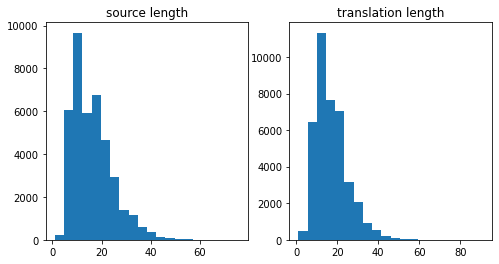

In [ ]:
src_length = map(len, [vars(x)['src'] for x in train_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in train_data.examples])

print('Length distribution in Train data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

Length distribution in Test data


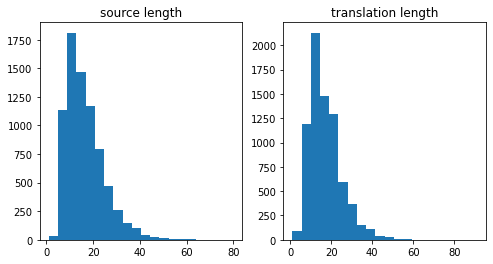

In [ ]:
src_length = map(len, [vars(x)['src'] for x in test_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in test_data.examples])

print('Length distribution in Test data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

# Модель

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
device

device(type='cuda')

In [ ]:
def _len_sort_key(x):
    return len(x.src)

BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort_key=_len_sort_key,
    sort_within_batch = True,
)

In [ ]:
for x in train_iterator:
    break
print(x)


[torchtext.data.batch.Batch of size 128]
	[.trg]:[torch.cuda.LongTensor of size 33x128 (GPU 0)]
	[.src]:('[torch.cuda.LongTensor of size 24x128 (GPU 0)]', '[torch.cuda.LongTensor of size 128 (GPU 0)]')


### Части сети

In [ ]:
from attention_network import *

### Построение сети

In [ ]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
ENC_HID_DIM = 512
DEC_HID_DIM = 512
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]

attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)

model = Seq2Seq(enc, dec, SRC_PAD_IDX, device).to(device)

In [ ]:
def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            torch.nn.init.xavier_uniform(param.data)
        else:
            nn.init.constant_(param.data, 0)
            
model.apply(init_weights)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  after removing the cwd from sys.path.


Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(6552, 256)
    (rnn): GRU(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn): Linear(in_features=1536, out_features=512, bias=True)
      (v): Linear(in_features=512, out_features=1, bias=False)
    )
    (embedding): Embedding(6784, 256)
    (rnn): GRU(1280, 512)
    (fc_out): Linear(in_features=1792, out_features=6784, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 22,011,008 trainable parameters


### Обучение сети

In [ ]:
PAD_IDX = TRG.vocab.stoi['<pad>']

optimizer = optim.Adam(model.parameters(), )
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)


In [ ]:
def train(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None):
    model.train()
    epoch_loss = 0
    history = []
    for i, batch in enumerate(iterator):
        src, src_len = batch.src
        trg = batch.trg
        optimizer.zero_grad()

    output = model(src, src_len, trg)
    #trg = [trg len, batch size]
    #output = [trg len, batch size, output dim]
        
    output_dim = output.shape[-1]
    output = output[1:].view(-1, output_dim)
    trg = trg[1:].view(-1)
        
    #trg = [(trg len - 1) * batch size]
    #output = [(trg len - 1) * batch size, output dim]
    
    loss = criterion(output, trg)
    loss.backward()
    
    torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
    optimizer.step()
    epoch_loss += loss.item()

    history.append(loss.cpu().data.numpy())
    if (i+1)%10==0:
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

        clear_output(True)
        ax[0].plot(history, label='train loss')
        ax[0].set_xlabel('Batch')
        ax[0].set_title('Train loss')
        if train_history is not None:
            ax[1].plot(train_history, label='general train history')
            ax[1].set_xlabel('Epoch')
        if valid_history is not None:
            ax[1].plot(valid_history, label='general valid history')
        plt.legend()
        plt.show()
        
    return epoch_loss / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion):  
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src, src_len = batch.src
            trg = batch.trg

            output = model(src, src_len, trg, 0) 
            
            #trg = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)

            #trg = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]

            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
train_history = []
valid_history = []

N_EPOCHS = 8
CLIP = 1

best_valid_loss = float('inf')

In [ ]:
N_EPOCHS = 8
CLIP = 1

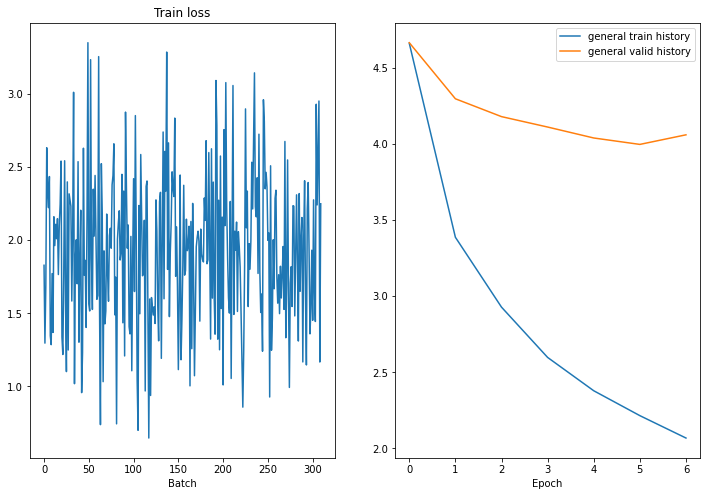

In [ ]:
epochs_time = list()

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epochs_time.append(epoch_time(start_time, end_time))

    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)

__Let's take a look at our network quality__:

### Тестирование сети

In [ ]:
from attention_utils import *

In [ ]:
for i, batch in enumerate(test_iterator):
    src, src_len = batch.src
    trg = batch.trg
    generate_translation(src, src_len, trg, model, TRG.vocab, SRC.vocab)
    break

Russian: предоставляться бесплатный частный парковка .
English: free private parking is available .
Generated: free private parking is available on site .



In [ ]:
from nltk.translate.bleu_score import corpus_bleu

#     """ Estimates corpora-level BLEU score of model's translations given inp and reference out """
#     translations, _ = model.translate_lines(inp_lines, **flags)
#     # Note: if you experience out-of-memory error, split input lines into batches and translate separately
#     return corpus_bleu([[ref] for ref in out_lines], translations) * 100

In [ ]:
import tqdm

In [ ]:
original_text = []
generated_text = []
model.eval()
with torch.no_grad():

    for i, batch in tqdm.tqdm(enumerate(test_iterator)):

        src, src_len = batch.src
        trg = batch.trg

        output = model(src, src_len, trg, 0) #turn off teacher forcing

        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]

        output = output.argmax(dim=-1)
        
        original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
        generated_text.extend([get_text(x, TRG.vocab) for x in output[1:].detach().cpu().numpy().T])

# original_text = flatten(original_text)
# generated_text = flatten(generated_text)

59it [00:05,  9.99it/s]


In [ ]:
corpus_bleu([[text] for text in original_text], generated_text) * 100

28.619690312774175